<a href="https://colab.research.google.com/github/EthanBrewerCity/NLP_CW_210008199/blob/main/NLP_CW_210008199.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##NLP Project: Ethan Brewer <br>
Dataset: Dair-ai/emotion <br>
Project Type: Sentiment Analysis <br>


#Add Setup Features for Project <br>
This Includes device setup, installs, imports and loading the original dataset

In [65]:
# Installs necessary
!pip install transformers
!pip install datasets

In [66]:
# Add imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Further imports via pytorch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW as Adam # Import AdamW optimiser as previous instance was "deprecated"

# Imports from prior pip installs
from datasets import load_dataset
from transformers import DistilBertModel, DistilBertTokenizer, AdamW # AdamW on this version is stated as "Deprecated" so other version from torch.optim is used

# Sklearn imports
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Load Dataset: dair-ai/emotion from Huggingface
dataset = load_dataset('emotion', trust_remote_code=True)

# Ensure the device being used is either the cuda or cpu (if cuda isn't available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Preprocessing the Data
The Tokeniser and Model are taken and the data is preprocessed via BERT (Currently Distilled)

In [67]:
# Load Tokeniser and Model for dataset, In this case, BERT (Distilled vers. may change later)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

## Create the Neural Network and Define the Model Architecture

In [68]:
# Defining Model Architecture + Added dropout
class SentiClass(nn.Module):
  def __init__(self,model):
    super(SentiClass, self).__init__()
    self.model = model
    self.linear = nn.Linear(768,1)
  def forward(self,input_ids, attention_mask):
    outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
    last_hidden_state = outputs.last_hidden_state[:, 0, :]
    logits = self.linear(last_hidden_state)
    return logits.squeeze(-1)

# Creating intstance of the model
model = SentiClass(model)

## Define the Train, Eval and Eval for confusion matrix

In [69]:
# Tokenize the data
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_dataset = dataset['train'].map(tokenize, batched=True)
test_dataset = dataset['test'].map(tokenize, batched=True)

# Set the data format
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Set up the optimizer and loss function
optimizer = Adam(model.parameters(), lr=5e-5,weight_decay=0.01)
# Old Loss function, not usable as it is binary
#loss_fn = nn.BCEWithLogitsLoss()
#New loss function
loss_fn = nn.CrossEntropyLoss()

# Define the training loop and prepare data for loss graph
def train(model, train_loader, optimizer, loss_fn, device,num_epochs):
    model.train()
    train_losses=[]
    for epoch in range(num_epochs):
      epoch_loss= 0.0
      for batch in train_loader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['label'].to(device)

          optimizer.zero_grad()
          outputs = model(input_ids, attention_mask)
          loss = loss_fn(outputs, labels.float())
          print(loss)
          loss.backward()
          optimizer.step()

          epoch_loss+=loss.item()
      epoch_loss /= len(train_loader)
      train_losses.append(epoch_loss)
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
    return train_losses

# Define the evaluation loop
def evaluate(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.round(torch.sigmoid(outputs))

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    return correct / total

def

##Training the model, adding padding and producing results for BERT

Streaming output truncated to the last 5000 lines.
tensor(183.3304, device='cuda:0', grad_fn=<DivBackward1>)
tensor(164.5687, device='cuda:0', grad_fn=<DivBackward1>)
tensor(122.7799, device='cuda:0', grad_fn=<DivBackward1>)
tensor(157.1926, device='cuda:0', grad_fn=<DivBackward1>)
tensor(140.5039, device='cuda:0', grad_fn=<DivBackward1>)
tensor(157.5395, device='cuda:0', grad_fn=<DivBackward1>)
tensor(182.5480, device='cuda:0', grad_fn=<DivBackward1>)
tensor(142.9475, device='cuda:0', grad_fn=<DivBackward1>)
tensor(190.8058, device='cuda:0', grad_fn=<DivBackward1>)
tensor(193.5780, device='cuda:0', grad_fn=<DivBackward1>)
tensor(129.5570, device='cuda:0', grad_fn=<DivBackward1>)
tensor(144.2523, device='cuda:0', grad_fn=<DivBackward1>)
tensor(193.9764, device='cuda:0', grad_fn=<DivBackward1>)
tensor(179.0363, device='cuda:0', grad_fn=<DivBackward1>)
tensor(136.1743, device='cuda:0', grad_fn=<DivBackward1>)
tensor(182.1251, device='cuda:0', grad_fn=<DivBackward1>)
tensor(182.7310, devi

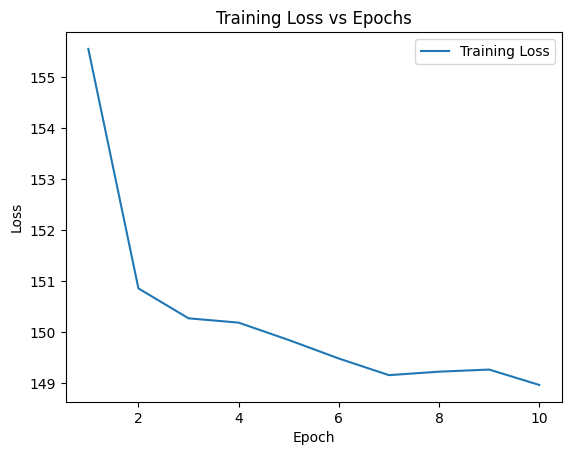

In [70]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Pad the sequences
def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  labels = [item['label'] for item in batch]

  input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
  attention_mask = pad_sequence(attention_mask,batch_first=True,padding_value=0)

  return {
      'input_ids': input_ids,
      'attention_mask': attention_mask,
      'label': torch.tensor(labels)
  }

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle = True, collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle = False, collate_fn = collate_fn)
# Set number of epochs
epoch_val = 10
history = train(model, train_loader, optimizer, loss_fn, device,epoch_val)
accuracy = evaluate(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.3f}')

# Loss graph for training
plt.plot(range(1, epoch_val + 1), history , label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.legend()
plt.show()
#for epoch in range(5):
#    history = train(model, train_loader, optimizer, loss_fn, device,epoch_val)
#    accuracy = evaluate(model, test_loader, device)
#    print(f'Epoch {epoch+1} - Test Accuracy: {accuracy:.3f}')